# <font color='red'>**Sequence to sequence implementation**</font>

### Implementation of Encoder and Decoder Model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [1]:
# pip install nltk
# !pip install prettytable
# !pip install seaborn
# pip install --upgrade pip

In [2]:
import pandas as pd
import numpy as  np
import pandas as pd
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from nltk.corpus import stopwords
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from tensorflow.keras.activations import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
for device in tf.config.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
tf.config.experimental_run_functions_eagerly(True)
warnings.filterwarnings("ignore")
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()
from bs4 import BeautifulSoup

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
data = pd.read_csv('/kaggle/input/nmt-data/ita.txt', sep = '\t', header = None, names = ['English', 'Italian', 'Info'], usecols = [0, 1])
data.head()

,English,Italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
stop_words = set(stopwords.words('english')) 
def preprocess(text_data):
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    text = []
    for sentance in tqdm(text_data):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = sentance.lower()
        text.append(sentance.strip())
    return np.array(text)

In [6]:
type(data.English.values)

numpy.ndarray

In [7]:
# Run if you want, you will get the data files in processed_data

eng = preprocess(data.English.values)
ita = preprocess(data.Italian.values)

100%|██████████| 354238/354238 [00:55<00:00, 6422.26it/s]


In [8]:
# eng = list(eng)
# ita = list(ita)

In [9]:
# eng = pd.DataFrame(eng)
# ita = pd.DataFrame(ita)
# eng.to_csv('eng_preprocessed.csv')
# ita.to_csv('ita_preprocessed.csv')

In [10]:
# eng = pd.read_csv('/kaggle/working/eng_preprocessed.csv')
# ita = pd.read_csv('/kaggle/working/ita_preprocessed.csv')
# eng = list(eng)
# ita = list(ita)

In [11]:
df = pd.DataFrame()
df['English']  = eng
df['Italian'] = ita
df.head(10)

,English,Italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte
5,who,chi
6,wow,wow
7,duck,amore
8,duck,tesoro
9,duck,immergiti


In [12]:
df.shape

(354238, 2)

In [13]:
df.to_csv('pre.csv')

### Till here, data gets pre-processed -  Stored in 'pre.csv'

In [14]:
df = pd.read_csv('//kaggle/working/pre.csv').iloc[:,1:]

df['Italian_len'] = df['Italian'].str.split().apply(len)
df['English_len'] = df['English'].str.split().apply(len)

df['Italian_len'] = df['Italian'].str.split().apply(len)
#df = df[df['Italian_len'] < 20]

df['English_len'] = df['English'].str.split().apply(len)
#df = df[df['English_len'] < 20]

df['English_inp'] = '<start> ' + df['English'].astype(str)
df['English_out'] = df['English'].astype(str) + ' <end>'

#df['Italian'] = '<start> ' + df['Italian'].astype(str)
#df['Italian'] = df['Italian'].astype(str) + ' <end>'

df = df.drop(['English','Italian_len','English_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

,Italian,English_inp,English_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [15]:
train, val = train_test_split(df, test_size = 0.2)

In [16]:
train.iloc[0]['English_inp'] = str(train.iloc[0]['English_inp'])+' <end>'
#train.iloc[0]['English_out'] = str(train.iloc[0]['English_out'])+' <end>'
train.head()

,Italian,English_inp,English_out
29491,grattatemi la schiena,<start> scratch my back <end>,scratch my back <end>
114516,dov diretta,<start> where are you heading,where are you heading <end>
26487,non ne ho bisogno,<start> i do not need it,i do not need it <end>
117966,lavorate la domenica,<start> do you work on sundays,do you work on sundays <end>
176488,tom disse a mary che ero pronto,<start> tom told mary i was ready,tom told mary i was ready <end>


In [17]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['Italian'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['English_inp'].values)

In [18]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12704
25099


In [19]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['Italian'].values
        self.decoder_inps = data['English_inp'].values
        self.decoder_outs = data['English_out'].values
        
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        
        self.max_len_eng = max_len_eng
        self.max_len_ita = max_len_ita

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

## <font color='blue'>**Implement custom encoder decoder**</font>

### <font color='blue'>**Encoder**</font>

In [20]:
class Encoder(Model):
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        
        self.input_length = input_length
        self.lstm_size = lstm_size
        
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Encoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Encoder_LSTM")
        
    def call(self, input_sequence, states = None):
          
        embed_out = self.embed(input_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, states)
        return lstm_out, lstm_h, lstm_c

    def initialize_states(self,batch_size):
        states_h = tf.keras.backend.zeros((batch_size, self.lstm_size))
        state_c = tf.keras.backend.zeros((batch_size, self.lstm_size))
        return states_h, state_c   

### <font color='blue'>**Decoder**</font>

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Decoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Decoder_LSTM")
  
    def call(self, output_sequence, initial_states):
        embed_out = self.embed(output_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, initial_states)
        return lstm_out, lstm_h, lstm_c            

### <font color='blue'>**Encoder-Decoder**</font>

In [22]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size = vocab_size_ita+1, embedding_size = 300, input_length = encoder_inputs_length,
                               lstm_size = 512)
        self.decoder = Decoder(out_vocab_size = vocab_size_eng+1, embedding_size = 300, input_length = decoder_inputs_length,
                               lstm_size = 512)
        self.dense = Dense(output_vocab_size, activation = 'softmax')
    
    def call(self, data):
        inp, targ = data[0], data[1]
        enc_out, state_h, state_c = self.encoder(inp)
        dec_out, _, _ = self.decoder(targ, [state_h, state_c])
        out = self.dense(dec_out)
        return out      

In [23]:
bs = 1024
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20, 20)
test_dataset  = Dataset(val, tknizer_ita, tknizer_eng, 20, 20)

train_dataloader = Dataloder(train_dataset, batch_size=bs)
test_dataloader = Dataloder(test_dataset, batch_size=bs)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [24]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model_1 = Encoder_decoder(encoder_inputs_length = 20, decoder_inputs_length = 20, output_vocab_size = vocab_size_eng)
model_1.compile('adam', loss = 'sparse_categorical_crossentropy')

In [25]:
# Try epochs = 50

early = tf.keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True)
model_1.fit(train_dataloader, epochs = 50, validation_data = (test_dataloader), steps_per_epoch = 150, validation_steps = 40, callbacks = [early])

Epoch 1/50
150/150 [==============================] - 59s 393ms/step - loss: 2.3111 - val_loss: 1.7229
Epoch 2/50
150/150 [==============================] - 60s 402ms/step - loss: 1.6585 - val_loss: 1.5532
Epoch 3/50
150/150 [==============================] - 59s 394ms/step - loss: 1.4760 - val_loss: 1.3962
Epoch 4/50
150/150 [==============================] - 59s 397ms/step - loss: 1.3577 - val_loss: 1.3039
Epoch 5/50
150/150 [==============================] - 60s 399ms/step - loss: 1.2485 - val_loss: 1.1865
Epoch 6/50
150/150 [==============================] - 60s 400ms/step - loss: 1.1400 - val_loss: 1.0923
Epoch 7/50
150/150 [==============================] - 60s 397ms/step - loss: 1.0441 - val_loss: 0.9976
Epoch 8/50
150/150 [==============================] - 59s 395ms/step - loss: 0.9447 - val_loss: 0.9034
Epoch 9/50
150/150 [==============================] - 60s 397ms/step - loss: 0.8500 - val_loss: 0.8214
Epoch 10/50
150/150 [==============================] - 58s 389ms/step - l

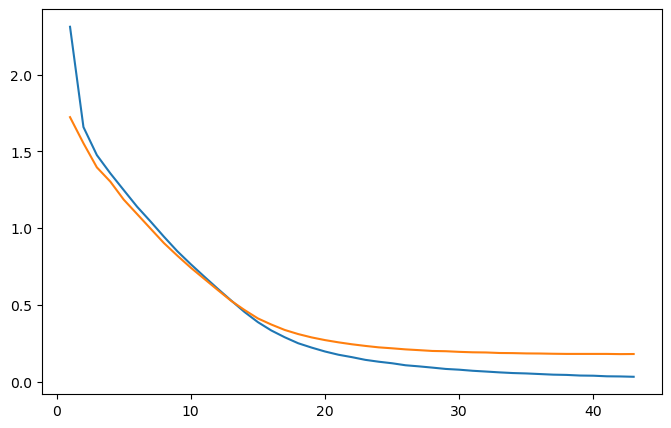

In [26]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['loss'])
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['val_loss'])
plt.show()

In [27]:
def predict(input_sentence):
    out_text = ''
    seq = tknizer_ita.texts_to_sequences([input_sentence]) 
    pad = pad_sequences(seq, maxlen = 20, dtype='int32', padding='post')
    enc_out, state_h, state_c = model_1.encoder(pad)
    intial = np.zeros((1,1), dtype = 'float32')
    intial[0, 0] = tknizer_eng.word_index['<start>']
    states = [state_h, state_c]
    
    for i in range(20):
        predicted_out, state_h, state_c = model_1.decoder(intial, initial_states = states)
        out = model_1.dense(predicted_out).numpy()
        out = out.reshape(out.shape[-1])
        states = [state_h, state_c] # Update State
        out = np.argmax(out)
        intial = np.zeros((1, 1), dtype = 'float32')
        if tknizer_eng.index_word[out] == '<end>' or i == 20:
            break
        intial[0, 0] = out #Update decoder input
        out_text += tknizer_eng.index_word[out] + ' '
    return out_text

In [28]:
res = pd.DataFrame()
res['Input'] = 0
res['Ground Truth'] = 0
res['Predicted'] = 0
res['Bleu Score'] = 0
m = np.random.randint(0, len(val), 10)
for n in tqdm(m):
    query = val.Italian.values[n]
    pred = predict(query)
    ground = val.English_inp.values[n][8:]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu = nltk.translate.bleu_score.sentence_bleu([ground_], pred_) 
    res = res.append({'Input' : query, 'Ground Truth': ground, 'Predicted' : pred, 'Bleu Score' : bleu},ignore_index= True)
res

100%|██████████| 10/10 [00:00<00:00, 17.55it/s]


,Input,Ground Truth,Predicted,Bleu Score
0,abito con mio zio adesso,i live with my uncle now,i live with my uncle now,1.000000
1,perch dovrei darti questo,why should i give this to you,why should i give this to you,1.000000
2,non sto dicendo che colpa di tom,i am not saying it is tom is fault,i am not saying it is tom is fault,1.000000
3,vorrei essere pi giovane,i wish i were younger,i wish i were younger,1.000000
4,libera di parlare con chiunque,you are free to talk with anyone,you are free to talk with anyone,1.000000
5,lei conosce l indirizzo di casa di tom,do you know tom is home address,do you know tom is house at the bush,0.446324
6,il paesaggio era mozzafiato,the scenery was breathtaking,the festival was amazing,0.840896
7,loro non vi ascolteranno,they will not listen to you,they will not listen to you,1.000000
8,io odio mia sorella,i hate my sister,i hate my sister,1.000000
9,voi avete letto il nuovo libro di tom,have you read tom is new book,have you read tom is new book,1.000000


In [29]:
model_1_bleu_score = np.mean(res['Bleu Score'].values)
print('Average Bleu Score: ', model_1_bleu_score)

Average Bleu Score:  0.9287220029039048
